In [85]:
# Import ggplot2 and dplyr for better visualization of large data sets
library(ggplot2)
library(dplyr)
library(GGally)
library(car)
library(MASS)
library(forcats)
library(boot)

In [58]:
df <- read.csv("combined_midwest_data_with_dup.csv")
attach(df)

dim((df))

The following objects are masked from df (pos = 6):

    AGE, AIR_BAGNAME, ALC_RES, ALC_RESNAME, ALC_STATUSNAME,
    ATST_TYPNAME, BODY_TYPNAME.y, DAY.x, DAYNAME.x, DAY_WEEK,
    DAY_WEEKNAME, DEATHS, DOANAME, DRINKINGNAME, DRUGSNAME, DR_DRINK,
    DR_DRINKNAME, EJECTIONNAME, EJ_PATHNAME, FATALS, FUNC_SYSNAME.x,
    HARM_EVNAME.x, HOUR.x, HOURNAME.x, INJ_SEV, INJ_SEVNAME,
    LGT_CONDNAME, MAN_COLLNAME.x, MINUTE.x, MINUTENAME.x, MONTH.x,
    MONTHNAME.x, PER_TYPNAME, REST_MIS, REST_MISNAME, REST_USENAME,
    ROUTENAME, RUR_URBNAME.x, SEAT_POSNAME, SEXNAME, SPEEDRELNAME,
    STATENAME.x, ST_CASE, TRAV_SP, TRAV_SPNAME, VALIGNNAME, VNUM_LAN,
    VNUM_LANNAME, VPAVETYPNAME, VPICBODYCLASSNAME.y, VPROFILENAME,
    VSPD_LIM, VSPD_LIMNAME, VSURCONDNAME, VTRAFWAYNAME, WEATHERNAME,
    YEAR


The following objects are masked from df (pos = 7):

    AGE, ALC_RES, ALC_RESNAME, DAY.x, DAYNAME.x, DAY_WEEK,
    DAY_WEEKNAME, DEATHS, DOANAME, DRINKINGNAME, DRUGSNAME,
    DR_DRINKNAME, FATALS, FUNC_SYS

[1] 39157    57

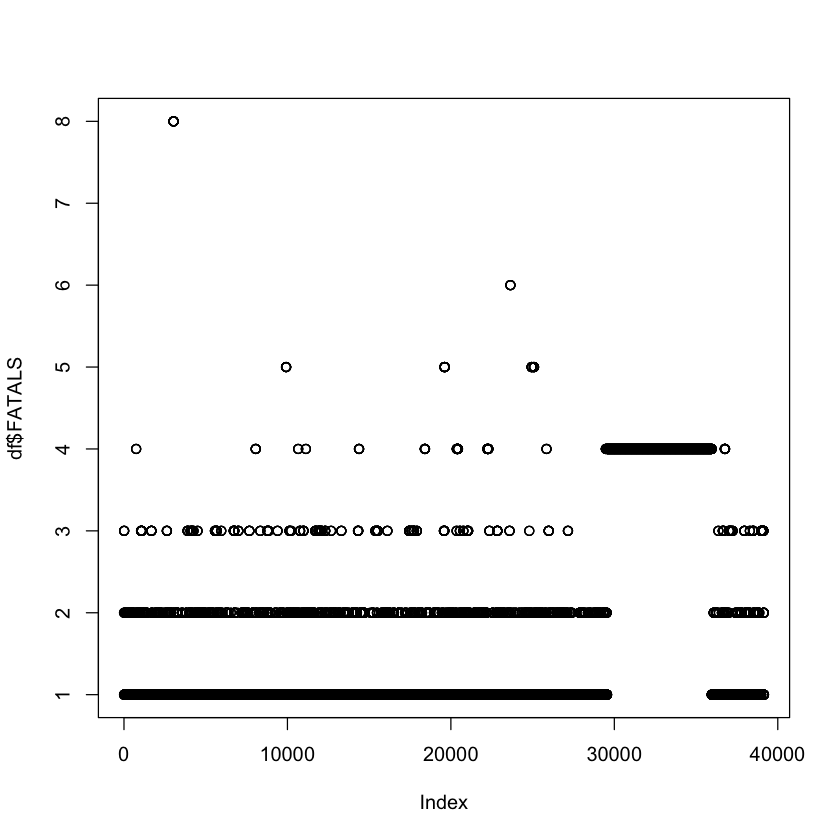

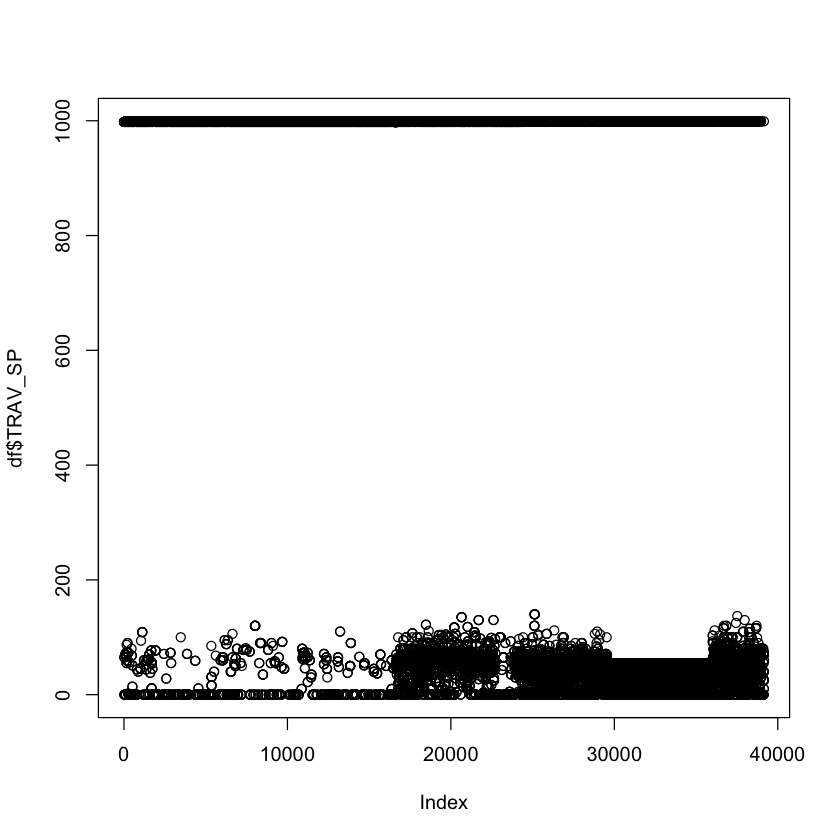

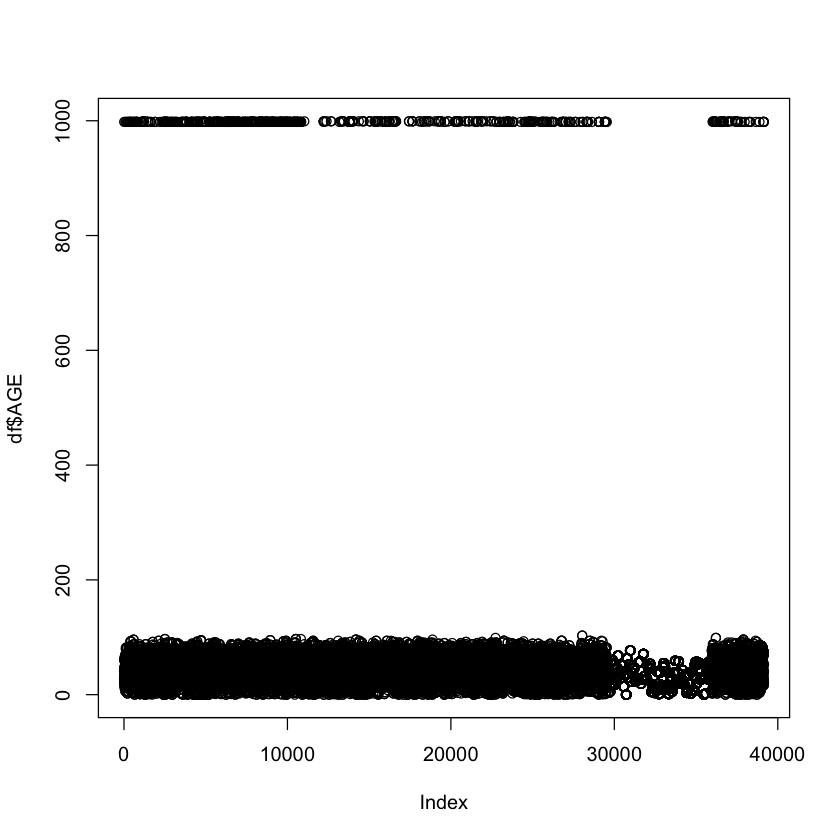

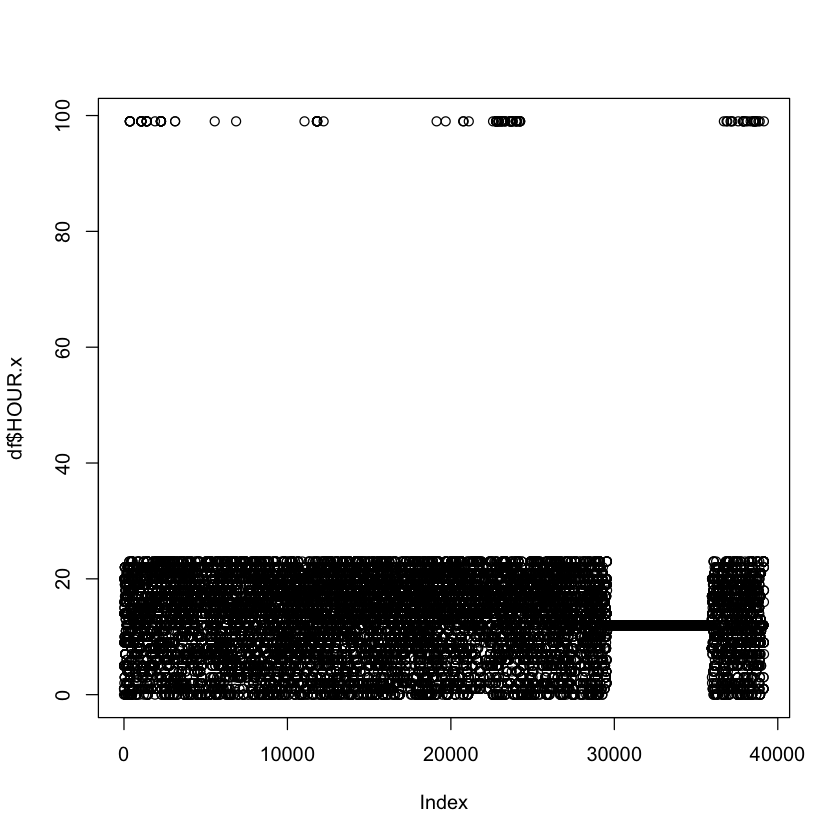

In [14]:
# Show the variables 
# Response: (FATALS)
# Categorical: (RUR-URBAN), (LGT_CONDNAME), (ROUTENAME)
# Continuous:(TRAV_SP) (AGE) (HOUR) 

# Continuous Variable Plots
plot(df$FATALS)
plot(df$TRAV_SP)
plot(df$AGE)
plot(df$HOUR.x)

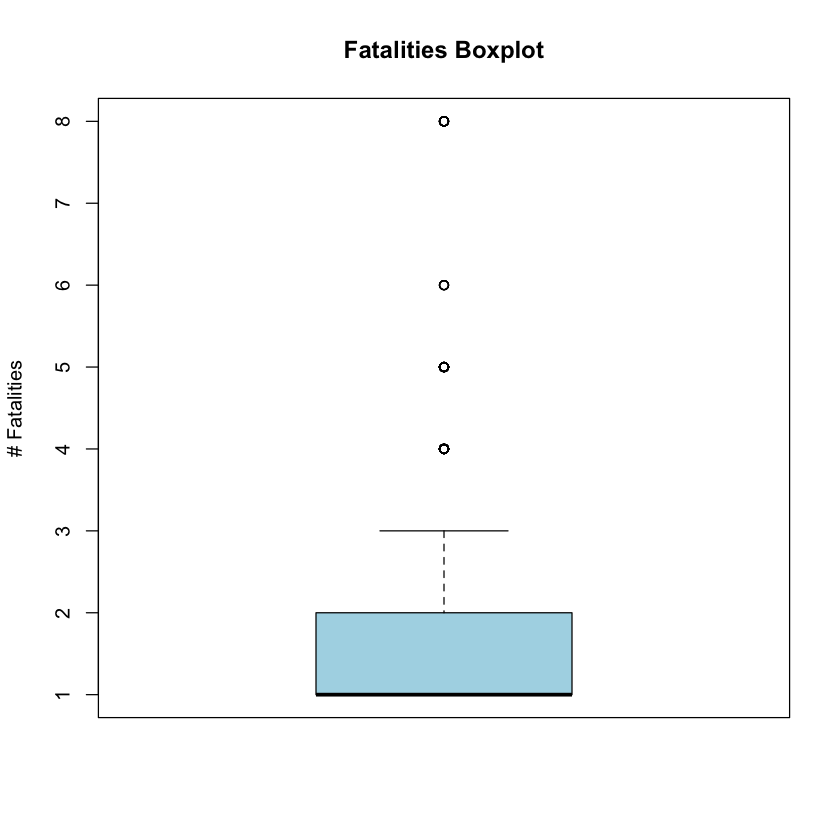

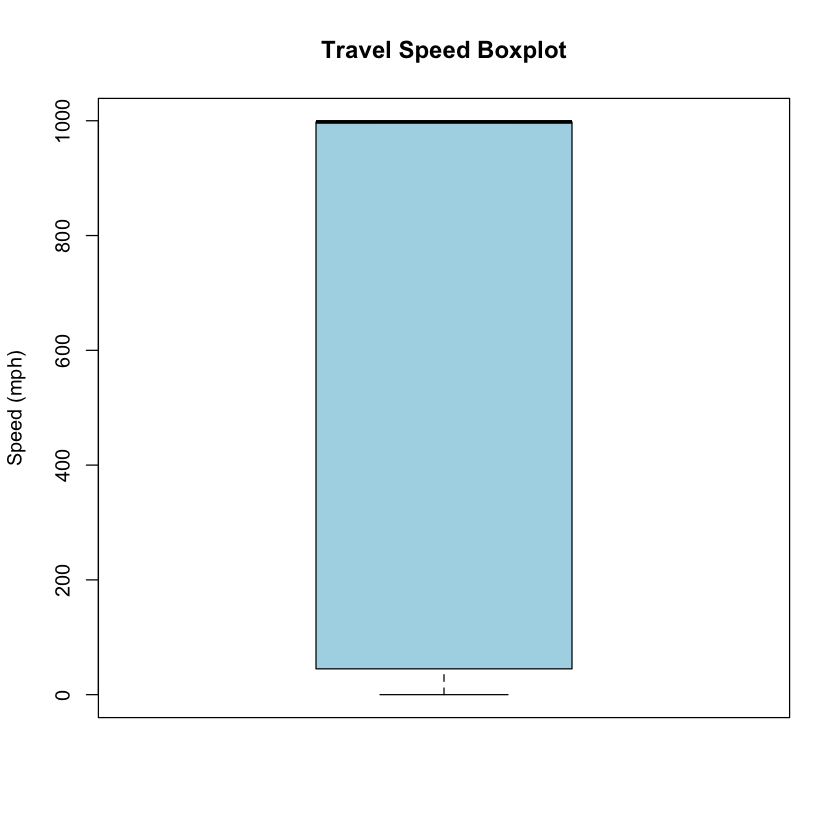

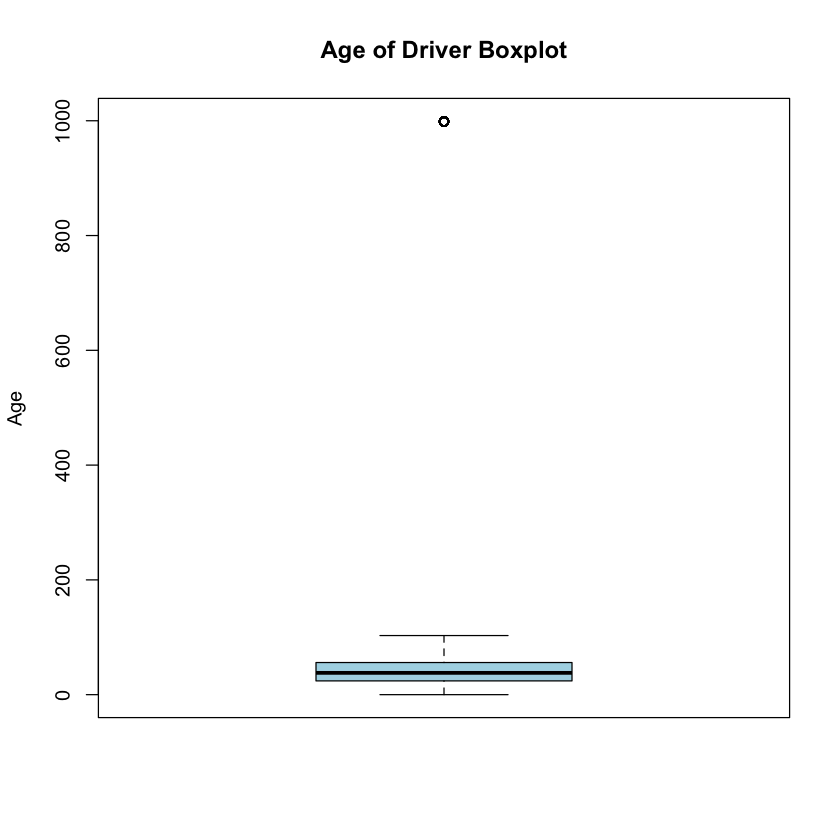

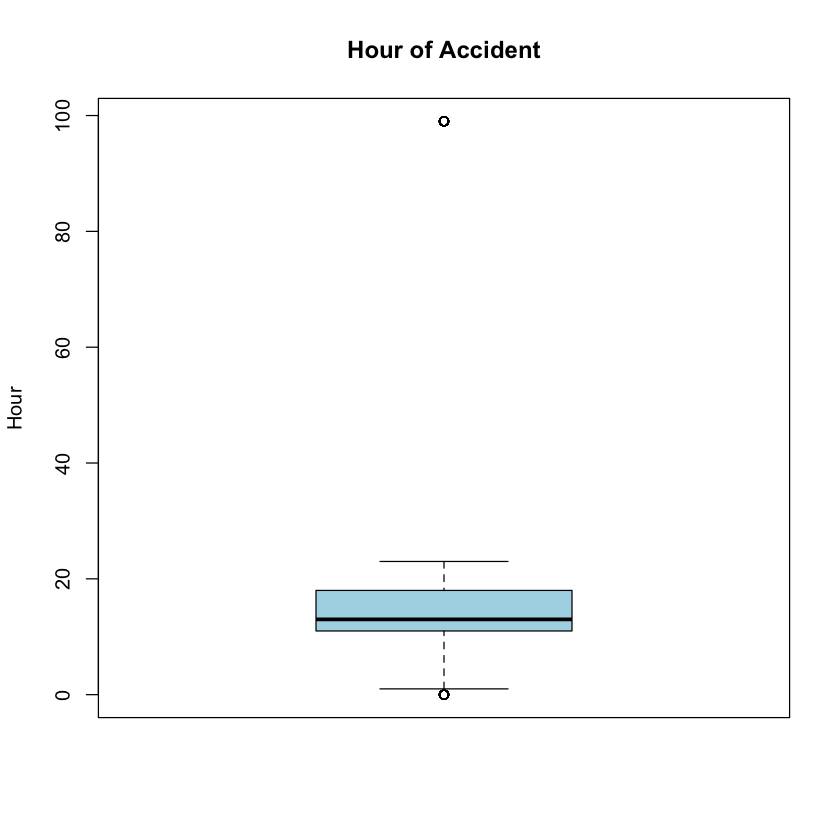

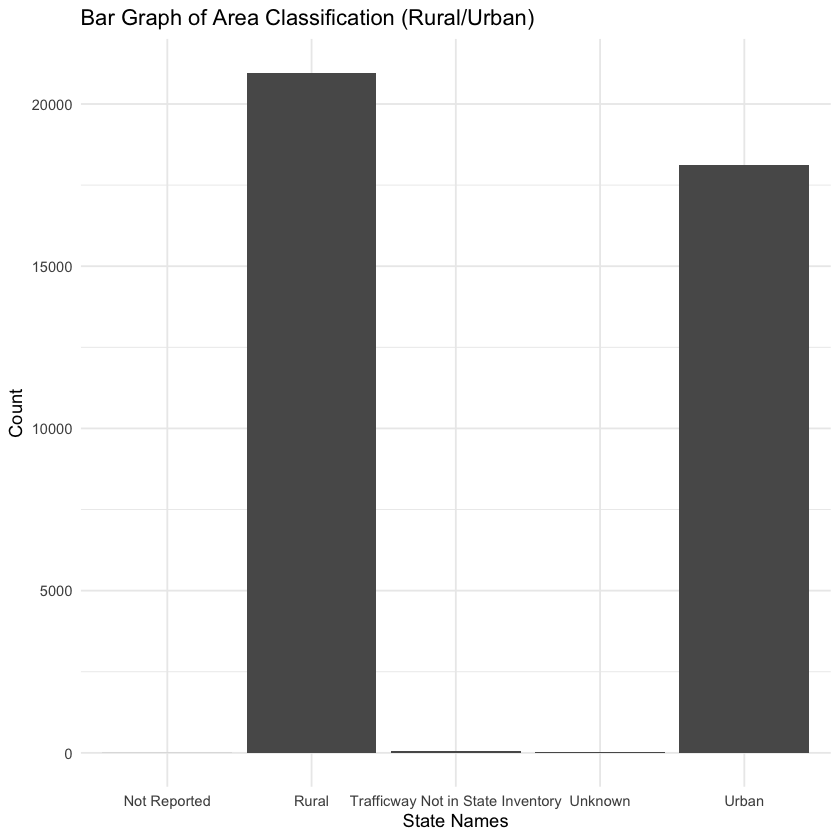

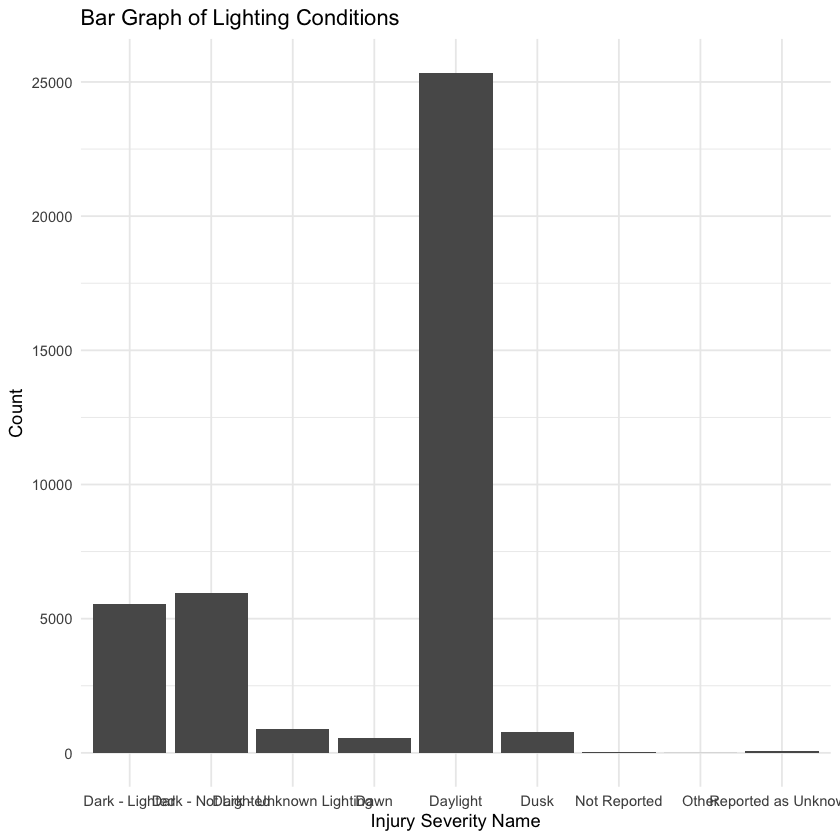

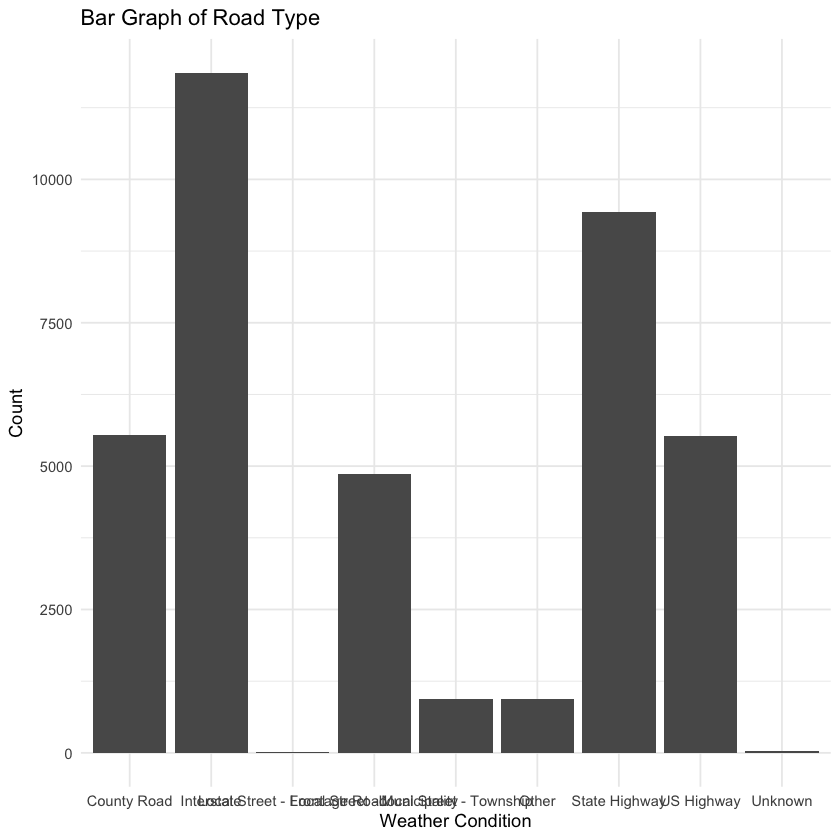

In [15]:
# Box-plots
boxplot(df$FATALS, main="Fatalities Boxplot", ylab="# Fatalities", col = "lightblue")
boxplot(df$TRAV_SP, main="Travel Speed Boxplot", ylab="Speed (mph)", col="lightblue")
boxplot(df$AGE, main="Age of Driver Boxplot", ylab="Age", col="lightblue")
boxplot(df$HOUR.x, main="Hour of Accident", ylab="Hour", col="lightblue")

# Initial Categorical Variable Plots - Bar Graphs
ggplot(df, aes(x = RUR_URBNAME.x)) +
  geom_bar() +
  labs(title = "Bar Graph of Area Classification (Rural/Urban)", x = "State Names", y = "Count") +
  theme_minimal()

ggplot(df, aes(x = LGT_CONDNAME)) +
  geom_bar() +
  labs(title = "Bar Graph of Lighting Conditions", x = "Injury Severity Name", y = "Count") +
  theme_minimal()

ggplot(df, aes(x = ROUTENAME)) +
  geom_bar() +
  labs(title = "Bar Graph of Road Type", x = "Weather Condition", y = "Count") +
  theme_minimal()

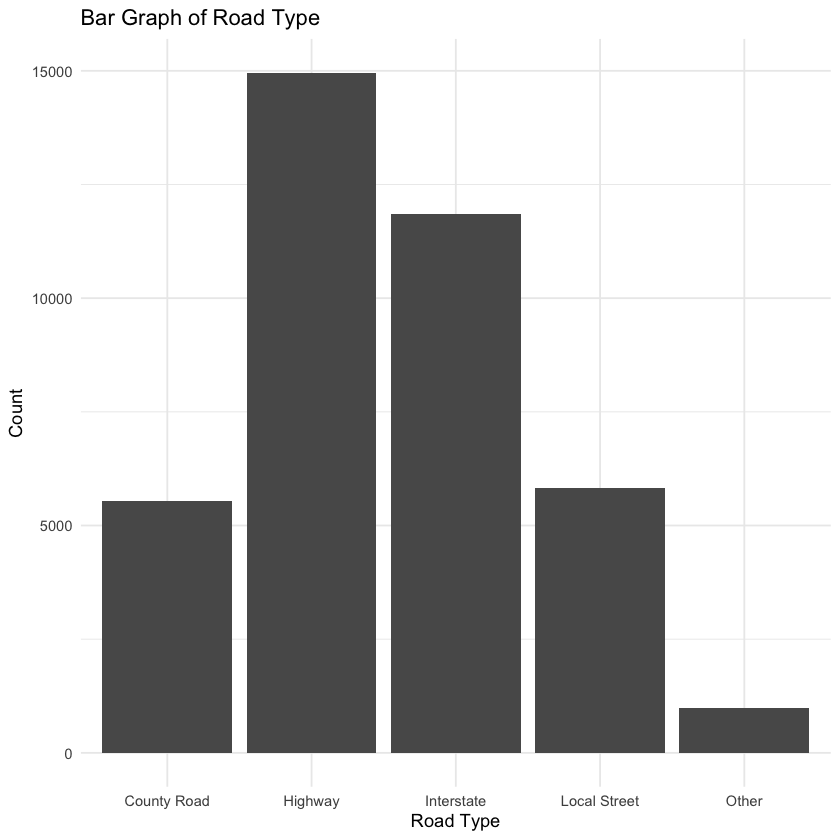

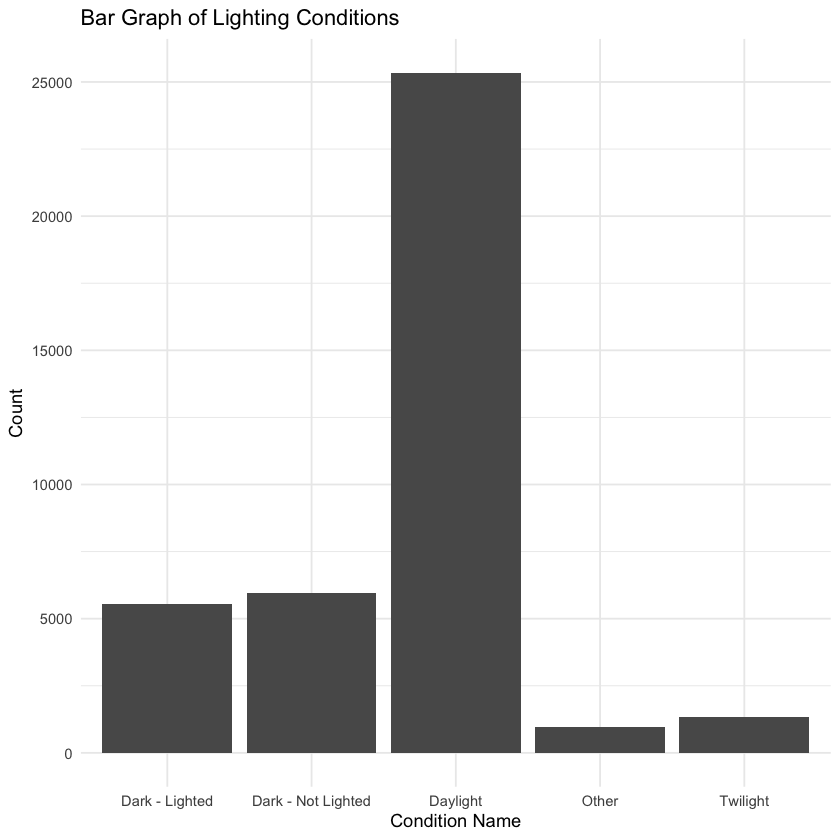

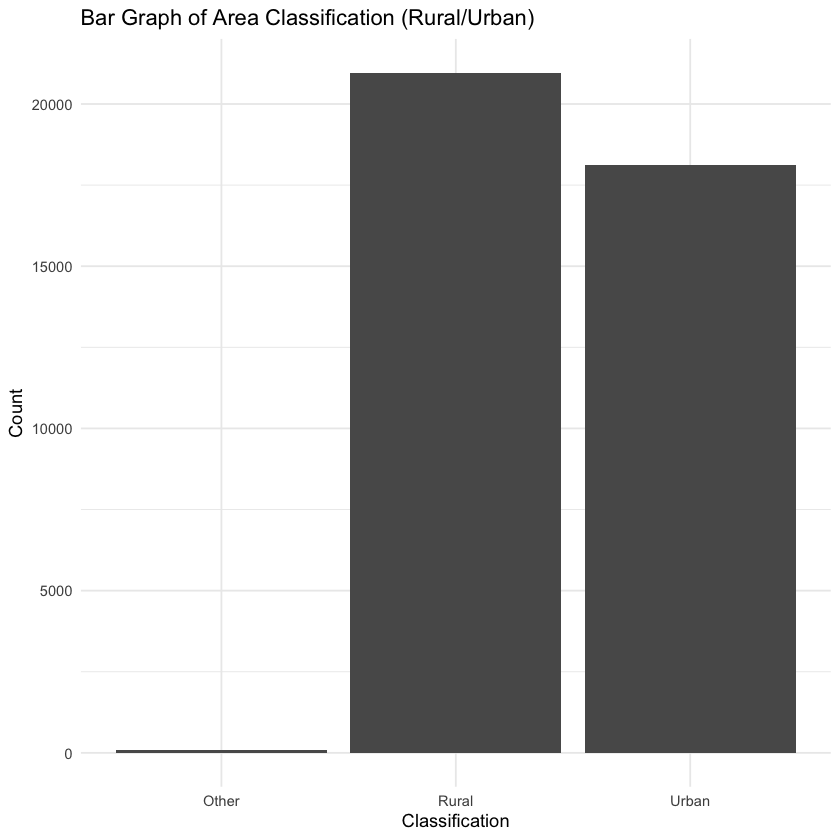

In [16]:
## VARIABLE VALUE CORRECTION - Combine Values for Categorical Variables ##
# ROUTENAME
df <- df %>%
  mutate(RouteCategory = case_when(
    ROUTENAME %in% c("County Road") ~ "County Road",
    ROUTENAME %in% c("Interstate") ~ "Interstate",
    ROUTENAME %in% c("Local Street - Frontage Road", "Local Street - Municipality", "Local Street - Township") ~ "Local Street",
    ROUTENAME %in% c("State Highway", "US Highway") ~ "Highway",
    TRUE ~ "Other"  # Catch-all for "Other" and "Unknown"
  ))

ggplot(df, aes(x = RouteCategory)) +
  geom_bar() +
  labs(title = "Bar Graph of Road Type", x = "Road Type", y = "Count") +
  theme_minimal()

# LGT_CONDNAME
df <- df %>%
  mutate(LightCond = case_when(
    LGT_CONDNAME %in% c("Dark - Lighted") ~ "Dark - Lighted",
    LGT_CONDNAME %in% c("Dark - Not Lighted") ~ "Dark - Not Lighted",
    LGT_CONDNAME %in% c("Daylight") ~ "Daylight",
    LGT_CONDNAME %in% c("Dusk", "Dawn") ~ "Twilight",
    TRUE ~ "Other"  # Catch-all for "Other" and "Unknown"
  ))

ggplot(df, aes(x = LightCond)) +
  geom_bar() +
  labs(title = "Bar Graph of Lighting Conditions", x = "Condition Name", y = "Count") +
  theme_minimal()

# RUR_URBNAME.x
df <- df %>%
  mutate(AreaClass = case_when(
    RUR_URBNAME.x %in% c("Rural") ~ "Rural",
    RUR_URBNAME.x %in% c("Urban") ~ "Urban",
    TRUE ~ "Other"  # Catch-all for "Other" and "Unknown"
  ))

ggplot(df, aes(x = AreaClass)) +
  geom_bar() +
  labs(title = "Bar Graph of Area Classification (Rural/Urban)", x = "Classification", y = "Count") +
  theme_minimal()

In [54]:
## VARIABLE VALUE CORRECTION - Remove Obvious Outliers from Continuous Variables ##
# Filter out rows in all continuous columns where the value is greater than or equal to 997
df_filtered <- df %>% filter(FATALS < 900, TRAV_SP < 900, AGE < 98, HOUR.x <= 24,
  RouteCategory != "Other",
  LightCond != "Other",
  AreaClass != "Other")

# Add sine and cosine transformations of HOUR.x
df_filtered <- df_filtered %>%
  mutate(HOUR_sin = sin(2 * pi * HOUR.x / 24),
         HOUR_cos = cos(2 * pi * HOUR.x / 24))

In [55]:
## SHOW CORRELATION ##
# Correlation Matrix for Continuous
subset_df <- df[c("FATALS", "TRAV_SP", "AGE", "HOUR.x")]
cor_matrix_sub <- cor(subset_df)
print(cor_matrix_sub)

             FATALS     TRAV_SP         AGE      HOUR.x
FATALS   1.00000000 -0.42690018 -0.09367553 -0.09172804
TRAV_SP -0.42690018  1.00000000  0.07637953  0.06279095
AGE     -0.09367553  0.07637953  1.00000000  0.02792726
HOUR.x  -0.09172804  0.06279095  0.02792726  1.00000000


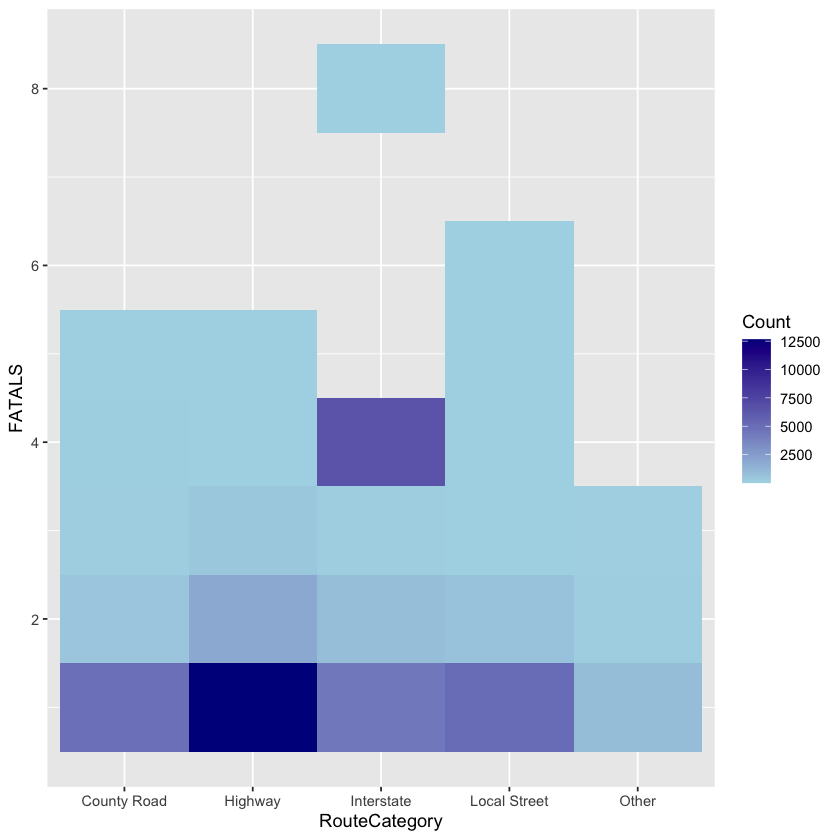

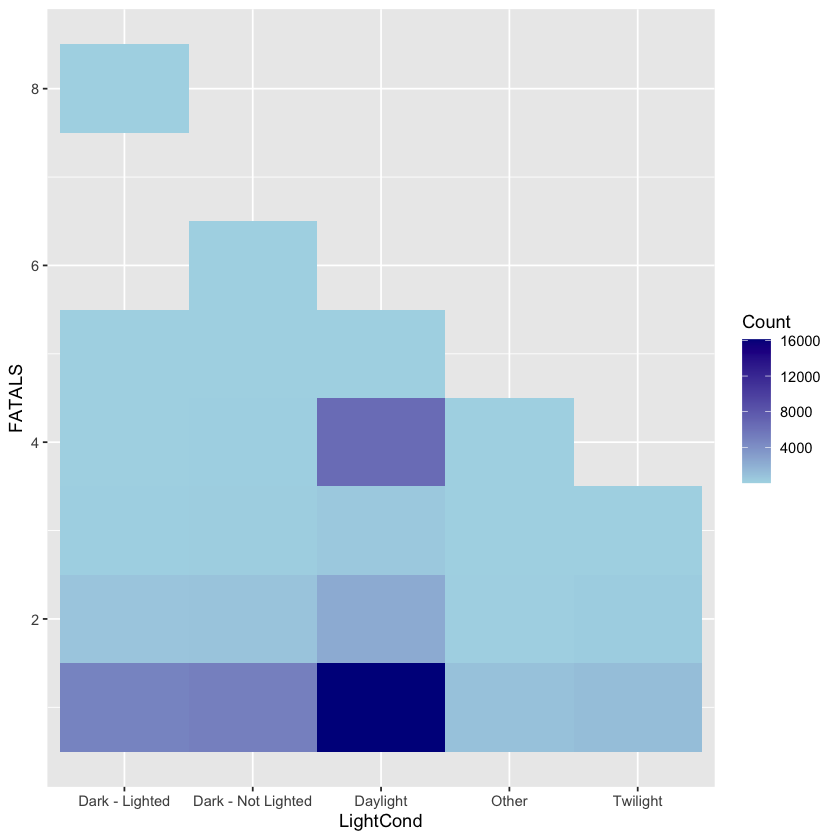

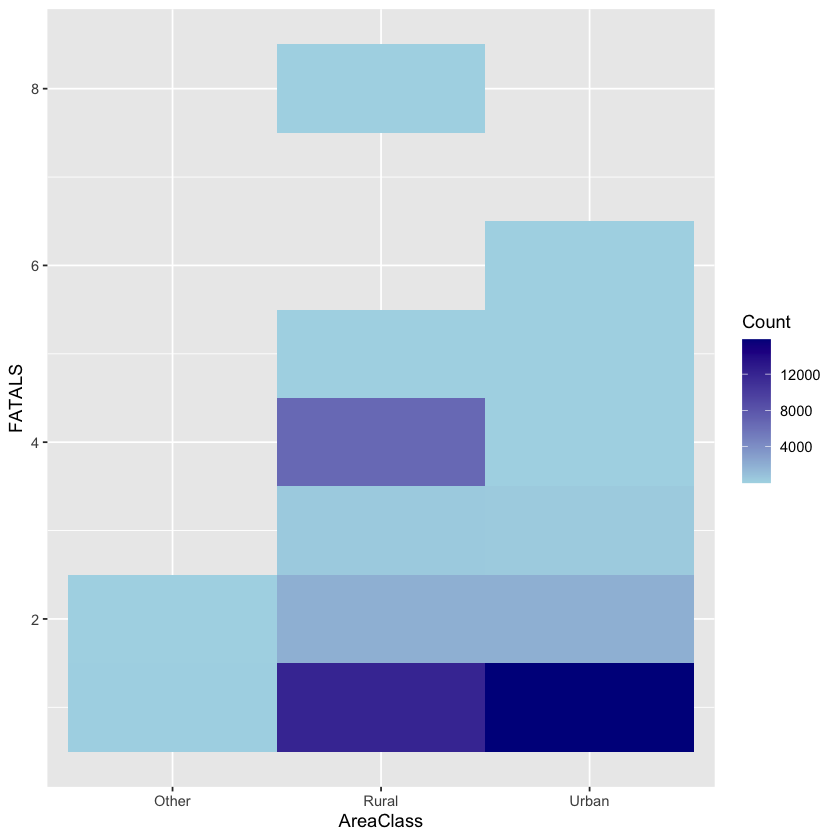

In [56]:
# Heat Maps for Categoricals
# Route x Fatalities
route_fatals_counts <- df %>%
  count(RouteCategory, FATALS)

ggplot(route_fatals_counts, aes(x = RouteCategory, y = FATALS, fill = n)) +
  geom_tile() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(fill = "Count")

# Lighting Conditions x Fatalities
light_fatals_counts <- df %>%
  count(LightCond, FATALS)

ggplot(light_fatals_counts, aes(x = LightCond, y = FATALS, fill = n)) +
  geom_tile() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(fill = "Count")

# Area Classification x Fatalities
area_fatals_counts <- df %>%
  count(AreaClass, FATALS)

ggplot(area_fatals_counts, aes(x = AreaClass, y = FATALS, fill = n)) +
  geom_tile() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(fill = "Count")


Call:
lm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    TRAV_SP + AGE + HOUR.x, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6994 -0.6349  0.3089  0.5433  2.9080 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  2.0121843  0.0451480  44.569  < 2e-16 ***
RouteCategoryHighway        -0.1224755  0.0245812  -4.982 6.34e-07 ***
RouteCategoryInterstate      1.4609963  0.0243334  60.041  < 2e-16 ***
RouteCategoryLocal Street    0.1770809  0.0336315   5.265 1.42e-07 ***
LightCondDark - Not Lighted -0.5059909  0.0323295 -15.651  < 2e-16 ***
LightCondDaylight            0.2368556  0.0273572   8.658  < 2e-16 ***
LightCondTwilight           -0.4080810  0.0513890  -7.941 2.14e-15 ***
AreaClassUrban              -0.9868094  0.0173365 -56.921  < 2e-16 ***
TRAV_SP                     -0.0008901  0.0002828  -3.147  0.00165 ** 
AGE                         -0.0061455  0.0003441 -17.857  < 2e

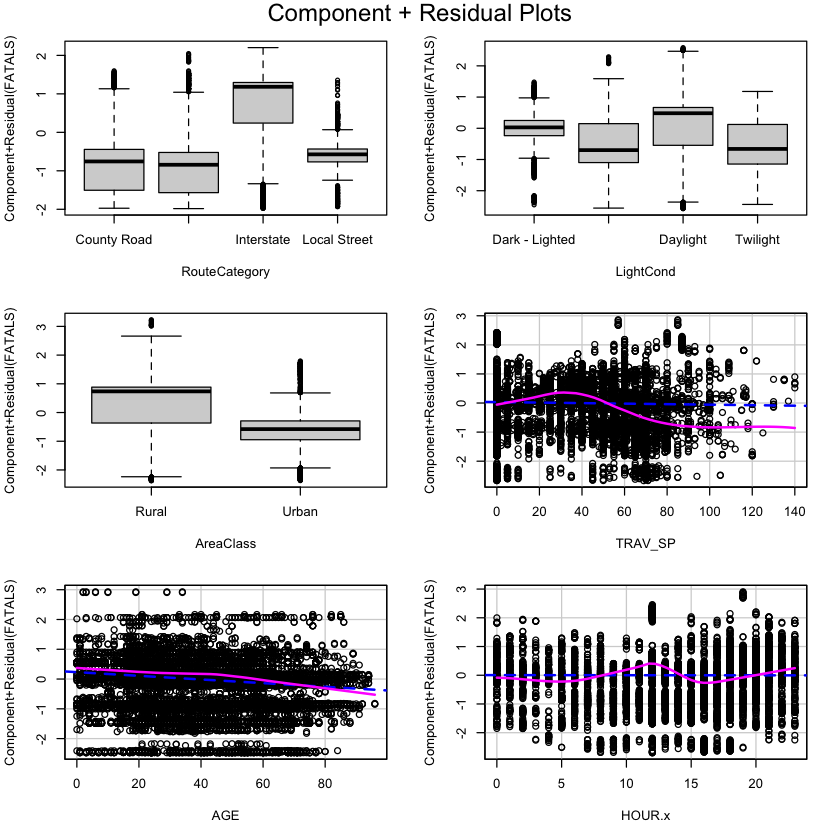

In [57]:
## RESIDUAL PLOTS ##
# Convert categorical variables to dummies
df_filtered$RouteCategory <- factor(df_filtered$RouteCategory)
df_filtered$LightCond <- factor(df_filtered$LightCond)
df_filtered$AreaClass <- factor(df_filtered$AreaClass)

model <- lm(FATALS ~ RouteCategory + LightCond + AreaClass + TRAV_SP + AGE + HOUR.x, data = df_filtered)

summary(model)
crPlots(model)

# added from original

In [ ]:
# Poisson Regression Model
poisson_model <- glm(FATALS ~ RouteCategory + LightCond + AreaClass + TRAV_SP + AGE + HOUR_sin + HOUR_cos, 
                     family = poisson(link = "log"), data = df_filtered)
summary(poisson_model)

# Quasi-Poisson to Handle Overdispersion
quasi_poisson_model <- glm(FATALS ~ RouteCategory + LightCond + AreaClass + TRAV_SP + AGE + HOUR_sin + HOUR_cos, 
                           family = quasipoisson(link = "log"), data = df_filtered)
summary(quasi_poisson_model)


Call:
glm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    TRAV_SP + AGE + HOUR_sin + HOUR_cos, family = poisson(link = "log"), 
    data = df_filtered)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  0.8231594  0.0415290  19.821  < 2e-16 ***
RouteCategoryHighway        -0.0704480  0.0259397  -2.716  0.00661 ** 
RouteCategoryInterstate      0.5820292  0.0243745  23.879  < 2e-16 ***
RouteCategoryLocal Street    0.0773383  0.0364481   2.122  0.03385 *  
LightCondDark - Not Lighted -0.2833227  0.0343905  -8.238  < 2e-16 ***
LightCondDaylight           -0.6088932  0.0415822 -14.643  < 2e-16 ***
LightCondTwilight           -0.4929547  0.0578152  -8.526  < 2e-16 ***
AreaClassUrban              -0.4525198  0.0173371 -26.101  < 2e-16 ***
TRAV_SP                      0.0002883  0.0002459   1.172  0.24106    
AGE                         -0.0023466  0.0002765  -8.486  < 2e-16 ***
HOUR_sin                    -0.0149


Call:
glm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    TRAV_SP + AGE + HOUR_sin + HOUR_cos, family = quasipoisson(link = "log"), 
    data = df_filtered)

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.8231594  0.0206363  39.889  < 2e-16 ***
RouteCategoryHighway        -0.0704480  0.0128898  -5.465 4.69e-08 ***
RouteCategoryInterstate      0.5820292  0.0121120  48.054  < 2e-16 ***
RouteCategoryLocal Street    0.0773383  0.0181115   4.270 1.97e-05 ***
LightCondDark - Not Lighted -0.2833227  0.0170891 -16.579  < 2e-16 ***
LightCondDaylight           -0.6088932  0.0206627 -29.468  < 2e-16 ***
LightCondTwilight           -0.4929547  0.0287291 -17.159  < 2e-16 ***
AreaClassUrban              -0.4525198  0.0086150 -52.527  < 2e-16 ***
TRAV_SP                      0.0002883  0.0001222   2.359   0.0183 *  
AGE                         -0.0023466  0.0001374 -17.078  < 2e-16 ***
HOUR_sin                    -0

In [60]:
interaction_model <- glm(FATALS ~ RouteCategory * LightCond + AreaClass + TRAV_SP + AGE + HOUR_sin + HOUR_cos, 
                         family = quasipoisson(link = "log"), data = df_filtered)
summary(interaction_model)


Call:
glm(formula = FATALS ~ RouteCategory * LightCond + AreaClass + 
    TRAV_SP + AGE + HOUR_sin + HOUR_cos, family = quasipoisson(link = "log"), 
    data = df_filtered)

Coefficients:
                                                        Estimate Std. Error
(Intercept)                                            0.7842583  0.0364708
RouteCategoryHighway                                   0.1197348  0.0400734
RouteCategoryInterstate                                0.0639808  0.0443773
RouteCategoryLocal Street                              0.1217900  0.0410834
LightCondDark - Not Lighted                           -0.1827398  0.0440015
LightCondDaylight                                     -0.5765198  0.0394888
LightCondTwilight                                     -0.3156710  0.0602989
AreaClassUrban                                        -0.4191186  0.0084323
TRAV_SP                                                0.0003302  0.0001192
AGE                                                

In [61]:
# Compare Models
AIC(poisson_model, quasi_poisson_model, interaction_model)

,df,AIC
,<dbl>,<dbl>
poisson_model,12,43371.25
quasi_poisson_model,13,NA
interaction_model,22,NA


In [62]:
nonlinear_model <- glm(FATALS ~ RouteCategory + LightCond + AreaClass + poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, 
                       family = quasipoisson(link = "log"), data = df_filtered)
summary(nonlinear_model)


Call:
glm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, family = quasipoisson(link = "log"), 
    data = df_filtered)

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.739736   0.019198  38.532  < 2e-16 ***
RouteCategoryHighway        -0.068816   0.012952  -5.313 1.09e-07 ***
RouteCategoryInterstate      0.569835   0.012232  46.586  < 2e-16 ***
RouteCategoryLocal Street    0.069863   0.018203   3.838 0.000124 ***
LightCondDark - Not Lighted -0.270263   0.017208 -15.705  < 2e-16 ***
LightCondDaylight           -0.590867   0.020857 -28.330  < 2e-16 ***
LightCondTwilight           -0.489379   0.028874 -16.949  < 2e-16 ***
AreaClassUrban              -0.439332   0.008752 -50.197  < 2e-16 ***
poly(TRAV_SP, 2)1           -0.078048   0.405126  -0.193 0.847235    
poly(TRAV_SP, 2)2           -4.327167   0.441671  -9.797  < 2e-16 ***
poly(AGE, 2)1          

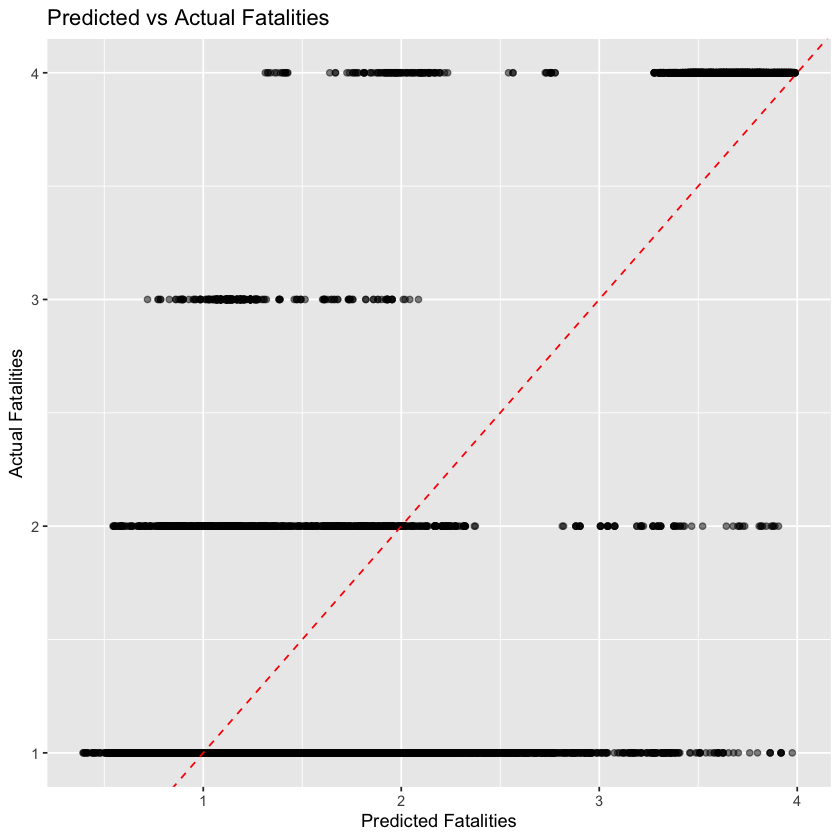

In [63]:
# Predicted vs Actual Plot
df_filtered$predicted <- predict(quasi_poisson_model, type = "response")
ggplot(df_filtered, aes(x = predicted, y = FATALS)) +
  geom_point(alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Predicted vs Actual Fatalities", x = "Predicted Fatalities", y = "Actual Fatalities")


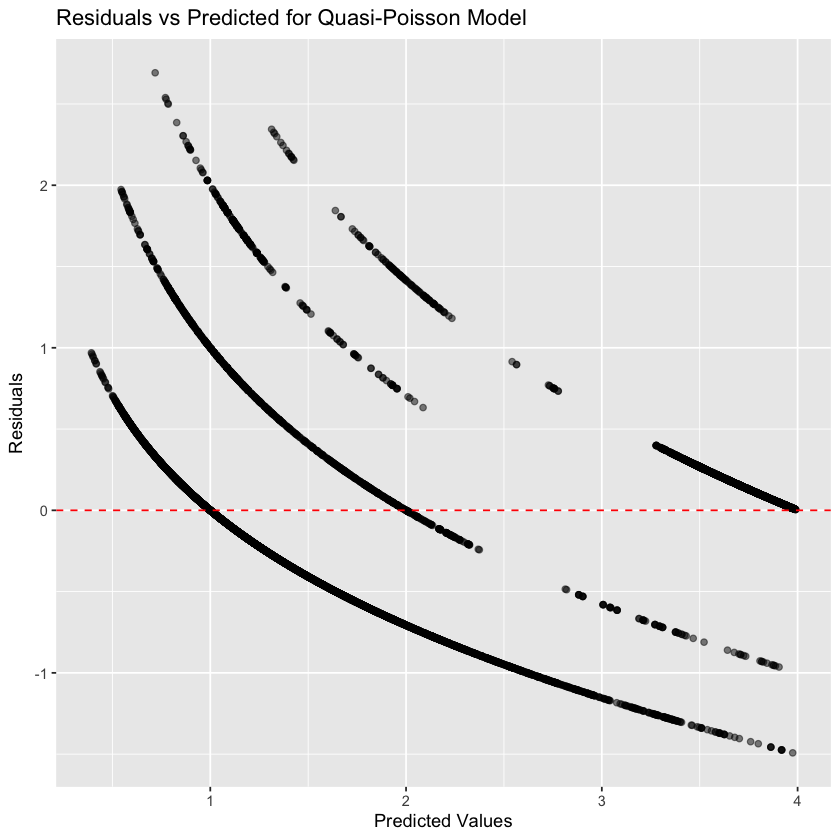

In [64]:
# Residual Plot
df_filtered$residuals <- residuals(quasi_poisson_model, type = "pearson")
ggplot(df_filtered, aes(x = predicted, y = residuals)) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Residuals vs Predicted for Quasi-Poisson Model", x = "Predicted Values", y = "Residuals")


Warning message:
"The following aesthetics were dropped during statistical transformation: fill.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"


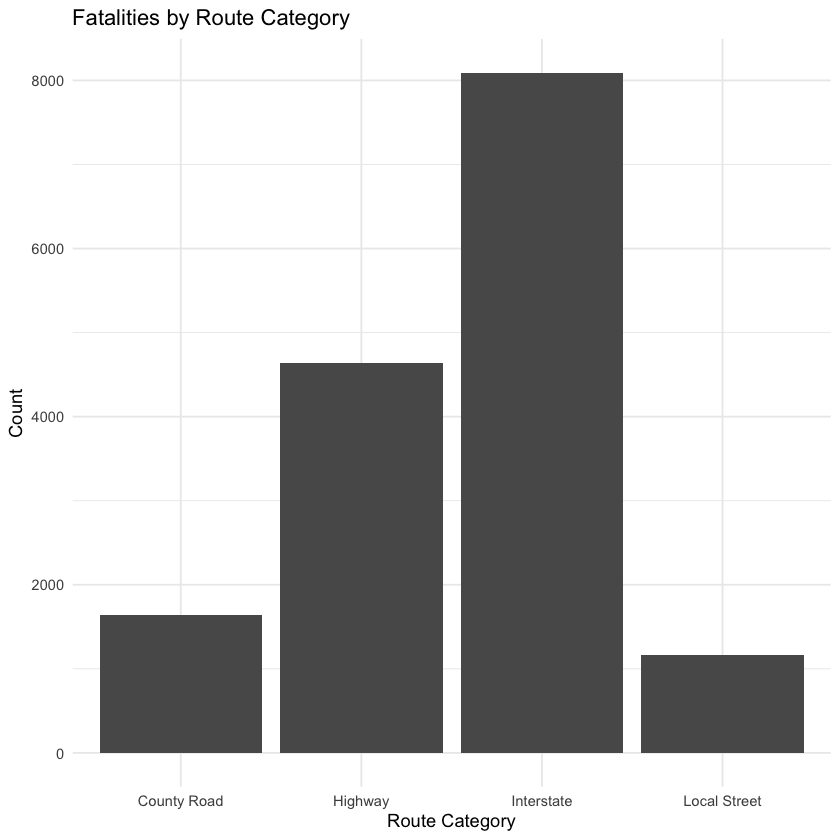

In [65]:
# Bar Plot for RouteCategory
ggplot(df_filtered, aes(x = RouteCategory, fill = FATALS)) +
  geom_bar(position = "dodge") +
  labs(title = "Fatalities by Route Category", x = "Route Category", y = "Count") +
  theme_minimal()

In [66]:
exp(coef(quasi_poisson_model))


(Intercept)        RouteCategoryHighway 
                  2.2776845                   0.9319762 
    RouteCategoryInterstate   RouteCategoryLocal Street 
                  1.7896663                   1.0804076 
LightCondDark - Not Lighted           LightCondDaylight 
                  0.7532767                   0.5439526 
          LightCondTwilight              AreaClassUrban 
                  0.6108190                   0.6360235 
                    TRAV_SP                         AGE 
                  1.0002884                   0.9976562 
                   HOUR_sin                    HOUR_cos 
                  0.9851575                   0.5645929

In [67]:
final_model <- glm(FATALS ~ RouteCategory * LightCond + AreaClass + 
                   poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, 
                   family = quasipoisson(link = "log"), data = df_filtered)
summary(final_model)


Call:
glm(formula = FATALS ~ RouteCategory * LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, family = quasipoisson(link = "log"), 
    data = df_filtered)

Coefficients:
                                                       Estimate Std. Error
(Intercept)                                            0.707211   0.035992
RouteCategoryHighway                                   0.132298   0.040282
RouteCategoryInterstate                                0.070946   0.044592
RouteCategoryLocal Street                              0.126163   0.041277
LightCondDark - Not Lighted                           -0.173074   0.044214
LightCondDaylight                                     -0.551417   0.039791
LightCondTwilight                                     -0.313612   0.060567
AreaClassUrban                                        -0.409706   0.008556
poly(TRAV_SP, 2)1                                      0.353133   0.391571
poly(TRAV_SP, 2)2                          

In [68]:
exp_coef <- exp(coef(final_model))
exp_confint <- exp(confint(final_model))
data.frame(Coefficient = names(exp_coef), Estimate = exp_coef, 
           `2.5%` = exp_confint[, 1], `97.5%` = exp_confint[, 2])


Waiting for profiling to be done...



,Coefficient,Estimate,X2.5.,X97.5.
,<chr>,<dbl>,<dbl>,<dbl>
(Intercept),(Intercept),2.028326766,1.888770900,2.175006209
RouteCategoryHighway,RouteCategoryHighway,1.141448839,1.055334987,1.235881508
RouteCategoryInterstate,RouteCategoryInterstate,1.073523261,0.983949748,1.171922833
RouteCategoryLocal Street,RouteCategoryLocal Street,1.134466876,1.046781280,1.230653363
LightCondDark - Not Lighted,LightCondDark - Not Lighted,0.841075235,0.771495637,0.917519899
LightCondDaylight,LightCondDaylight,0.576132591,0.533215868,0.623233943
LightCondTwilight,LightCondTwilight,0.730802583,0.648488304,0.822323498
AreaClassUrban,AreaClassUrban,0.663845092,0.652792923,0.675058379
"poly(TRAV_SP, 2)1","poly(TRAV_SP, 2)1",1.423520663,0.660396713,3.064949254


Warning message in plot.window(...):
""id.method" is not a graphical parameter"
Warning message in plot.xy(xy, type, ...):
""id.method" is not a graphical parameter"
Warning message in axis(side = side, at = at, labels = labels, ...):
""id.method" is not a graphical parameter"
Warning message in axis(side = side, at = at, labels = labels, ...):
""id.method" is not a graphical parameter"
Warning message in box(...):
""id.method" is not a graphical parameter"
Warning message in title(...):
""id.method" is not a graphical parameter"
Warning message in plot.xy(xy.coords(x, y), type = type, ...):
""id.method" is not a graphical parameter"


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
2215,2.8463029,0.0088895047,0.0046131607
2216,2.8476634,0.0088804645,0.0046141765
4923,4.2264664,0.0008681065,0.0011401137
4925,4.0655679,0.0009435705,0.0011108633
14172,-1.3057857,0.0437606036,0.0027352043
15050,-0.7673941,0.0353906914,0.0008021363


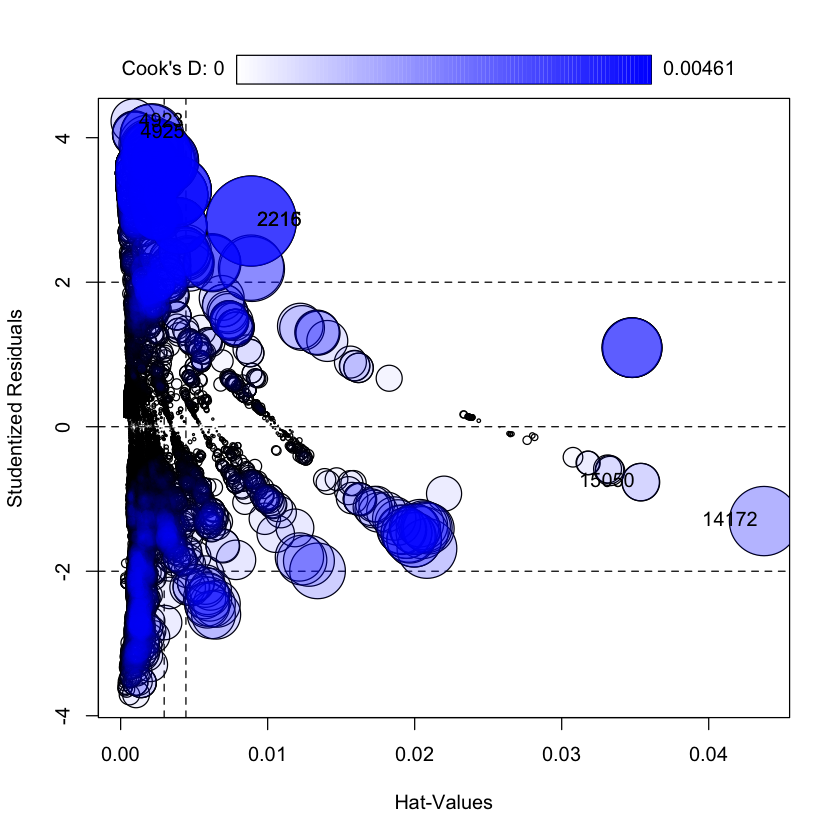

In [69]:
library(car)
influencePlot(final_model, id.method = "identify")

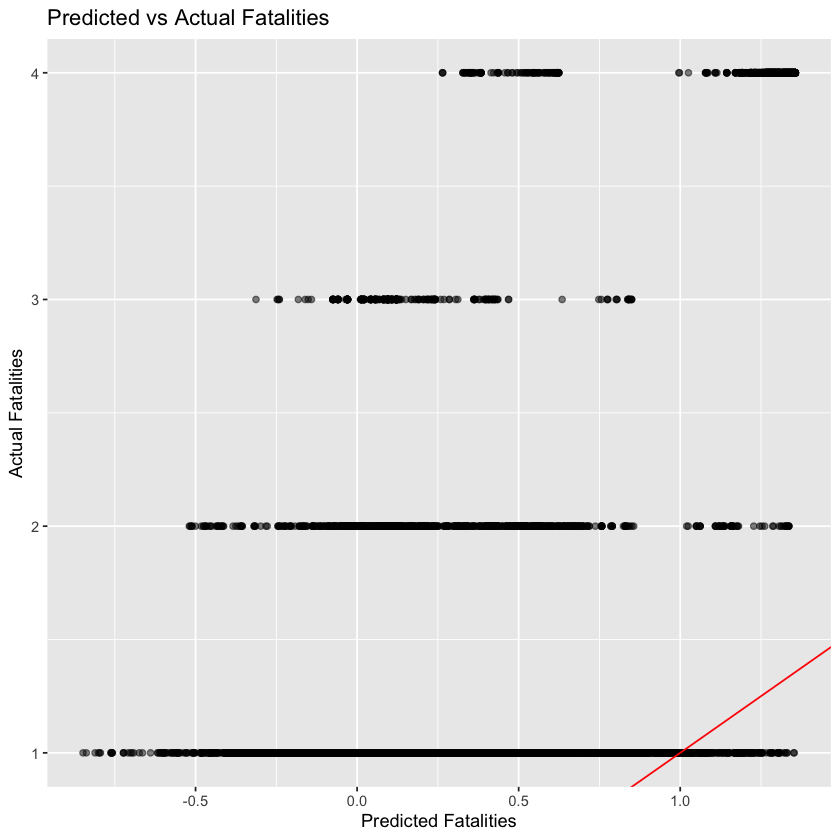

In [73]:
ggplot(df_filtered, aes(x = predict(final_model), y = FATALS)) +
  geom_point(alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Predicted vs Actual Fatalities", x = "Predicted Fatalities", y = "Actual Fatalities")

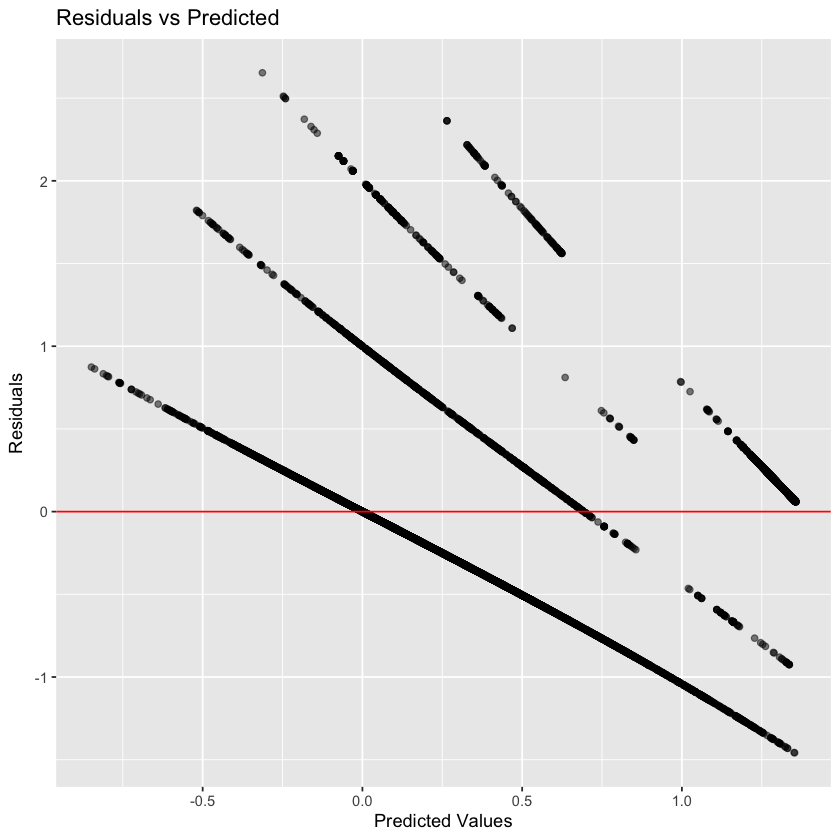

In [74]:
ggplot(df_filtered, aes(x = predict(final_model), y = residuals(final_model, type = "pearson"))) +
  geom_point(alpha = 0.5) +
  geom_hline(yintercept = 0, color = "red") +
  labs(title = "Residuals vs Predicted", x = "Predicted Values", y = "Residuals")

`summarise()` has grouped output by 'RouteCategory'. You can override using the
`.groups` argument.


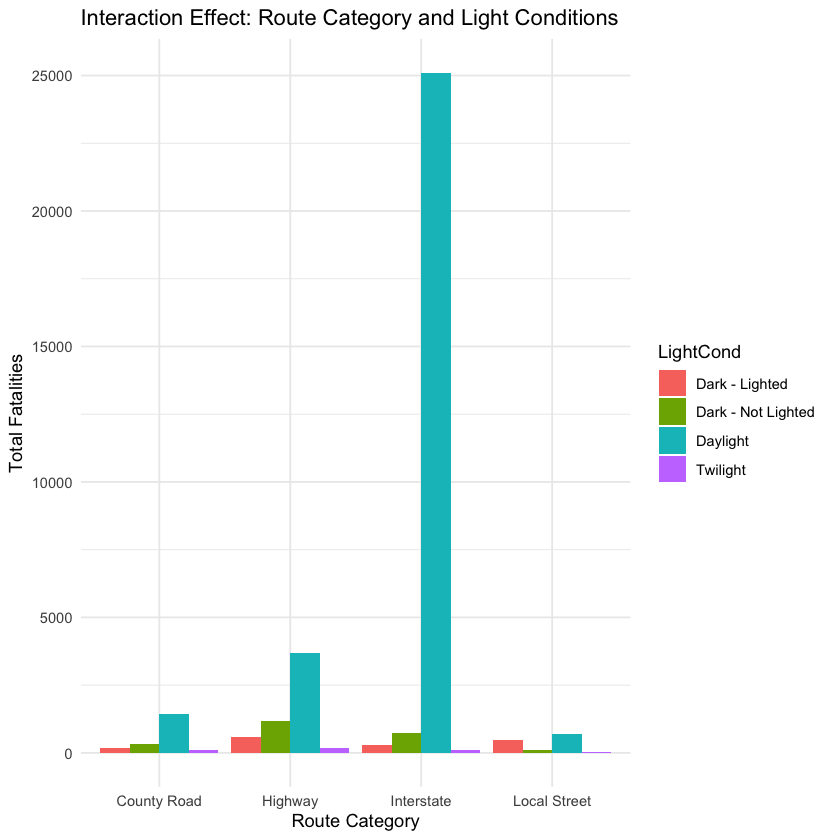

In [79]:
# Aggregate data for RouteCategory and LightCond
interaction_data <- df_filtered %>%
  group_by(RouteCategory, LightCond) %>%
  summarise(TotalFatalities = sum(FATALS, na.rm = TRUE))

# Create the interaction plot
interaction_plot <- ggplot(interaction_data, aes(x = RouteCategory, y = TotalFatalities, fill = LightCond)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Interaction Effect: Route Category and Light Conditions", 
       x = "Route Category", y = "Total Fatalities") +
  theme_minimal()

# Print the plot
print(interaction_plot)

In [86]:
# Calculate Pseudo R-squared
null_deviance <- final_model$null.deviance
residual_deviance <- final_model$deviance
pseudo_r2 <- 1 - (residual_deviance / null_deviance)
cat("Pseudo R^2: ", pseudo_r2, "\n")

Pseudo R^2:  0.7537667 


In [81]:
# Predictions
df_filtered$predicted <- predict(final_model, type = "response")

# Calculate MSE and MAE
mse <- mean((df_filtered$FATALS - df_filtered$predicted)^2)
mae <- mean(abs(df_filtered$FATALS - df_filtered$predicted))
cat("Mean Squared Error (MSE): ", mse, "\n")
cat("Mean Absolute Error (MAE): ", mae, "\n")


Mean Squared Error (MSE):  0.3986631 
Mean Absolute Error (MAE):  0.4292414 


In [82]:
# Split data into training and testing sets (70/30 split)
set.seed(123)  # For reproducibility
train_indices <- sample(1:nrow(df_filtered), size = 0.7 * nrow(df_filtered))
train_data <- df_filtered[train_indices, ]
test_data <- df_filtered[-train_indices, ]

# Fit model on training data
train_model <- glm(FATALS ~ RouteCategory * LightCond + AreaClass + 
                   poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, 
                   family = quasipoisson(link = "log"), data = train_data)

# Predict on test data
test_data$predicted <- predict(train_model, newdata = test_data, type = "response")

# Calculate test MSE and MAE
test_mse <- mean((test_data$FATALS - test_data$predicted)^2)
test_mae <- mean(abs(test_data$FATALS - test_data$predicted))
cat("Test Mean Squared Error (MSE): ", test_mse, "\n")
cat("Test Mean Absolute Error (MAE): ", test_mae, "\n")

# Compare train vs. test errors
cat("Train/Test Error Ratio (MSE): ", mse / test_mse, "\n")

Test Mean Squared Error (MSE):  0.3917357 
Test Mean Absolute Error (MAE):  0.4243534 
Train/Test Error Ratio (MSE):  1.017684 


In [ ]:
# 10-fold Cross-Validation
cv_results <- cv.glm(data = df_filtered, glmfit = final_model, K = 10)

# Cross-validated MSE
cat("Cross-validated MSE: ", cv_results$delta[1], "\n")

Cross-validated MSE:  0.3998988 
